In [35]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import copy
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
games_df = pd.read_csv('games.csv')
games_df.head()

,GAME_DATE_EST,GAME_ID,GAME_STATUS_TEXT,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,...,AST_home,REB_home,TEAM_ID_away,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS
0,2022-12-22,22200477,Final,1610612740,1610612759,2022,1610612740,126.0,0.484,0.926,...,25.0,46.0,1610612759,117.0,0.478,0.815,0.321,23.0,44.0,1
1,2022-12-22,22200478,Final,1610612762,1610612764,2022,1610612762,120.0,0.488,0.952,...,16.0,40.0,1610612764,112.0,0.561,0.765,0.333,20.0,37.0,1
2,2022-12-21,22200466,Final,1610612739,1610612749,2022,1610612739,114.0,0.482,0.786,...,22.0,37.0,1610612749,106.0,0.470,0.682,0.433,20.0,46.0,1
3,2022-12-21,22200467,Final,1610612755,1610612765,2022,1610612755,113.0,0.441,0.909,...,27.0,49.0,1610612765,93.0,0.392,0.735,0.261,15.0,46.0,1
4,2022-12-21,22200468,Final,1610612737,1610612741,2022,1610612737,108.0,0.429,1.000,...,22.0,47.0,1610612741,110.0,0.500,0.773,0.292,20.0,47.0,0


/Users/atirumalai/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/atirumalai/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


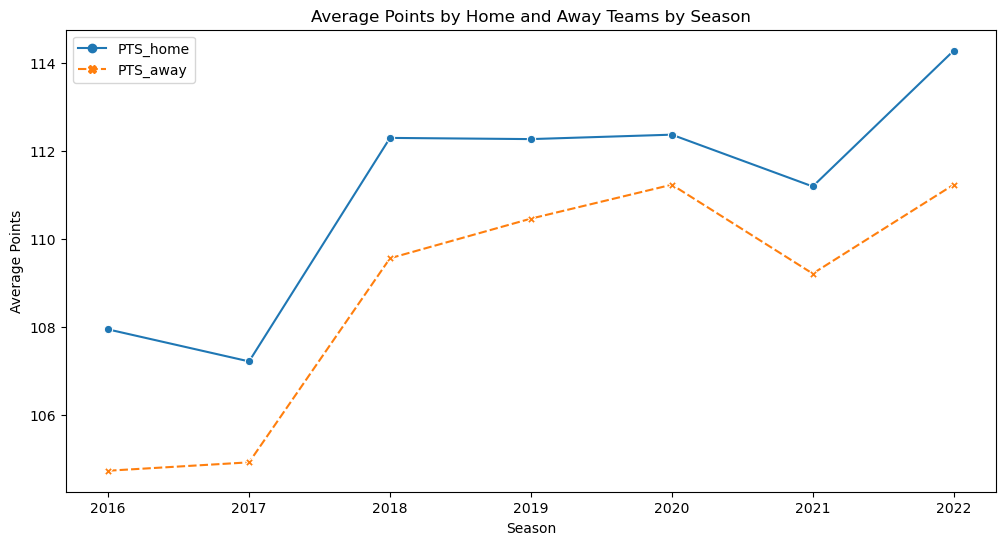

In [39]:
# Calculate the average points by home and away teams by season
avg_points_by_season = games_df.groupby('SEASON')[['PTS_home', 'PTS_away']].mean()

# Plot the average points by home and away teams by season
plt.figure(figsize=(12, 6))
sns.lineplot(data=avg_points_by_season, markers=True)
plt.title('Average Points by Home and Away Teams by Season')
plt.xlabel('Season')
plt.ylabel('Average Points')
plt.show()


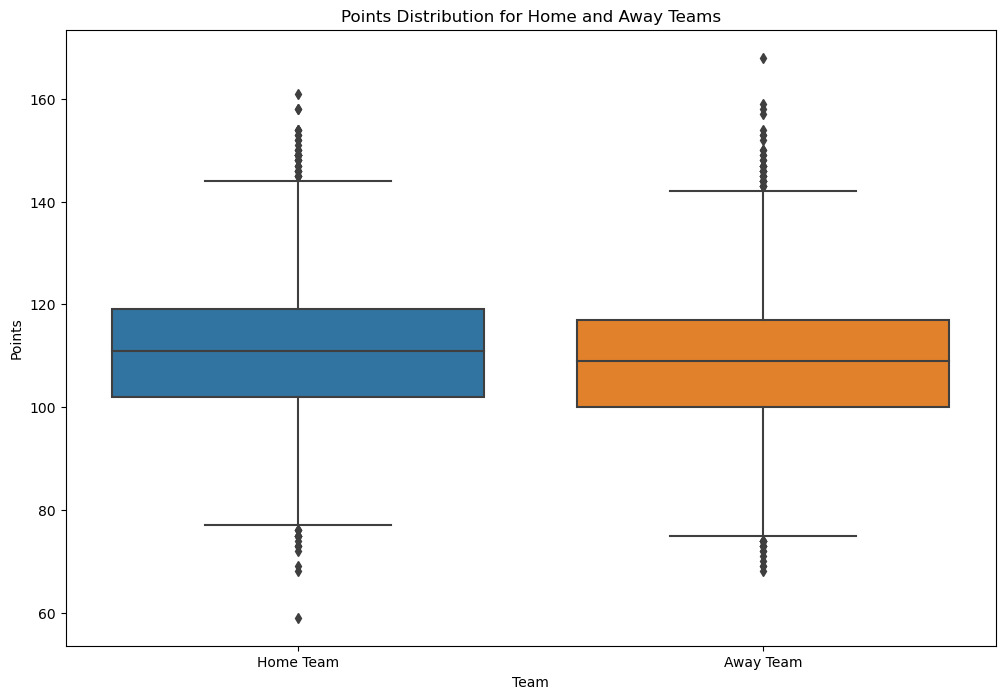

In [43]:
# Plot box plots of points distribution for home and away teams
plt.figure(figsize=(12, 8))
sns.boxplot(data=games_df[['PTS_home', 'PTS_away']])
plt.title('Points Distribution for Home and Away Teams')
plt.xlabel('Team')
plt.ylabel('Points')
plt.xticks([0, 1], ['Home Team', 'Away Team'])
plt.show()


/Users/atirumalai/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/atirumalai/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


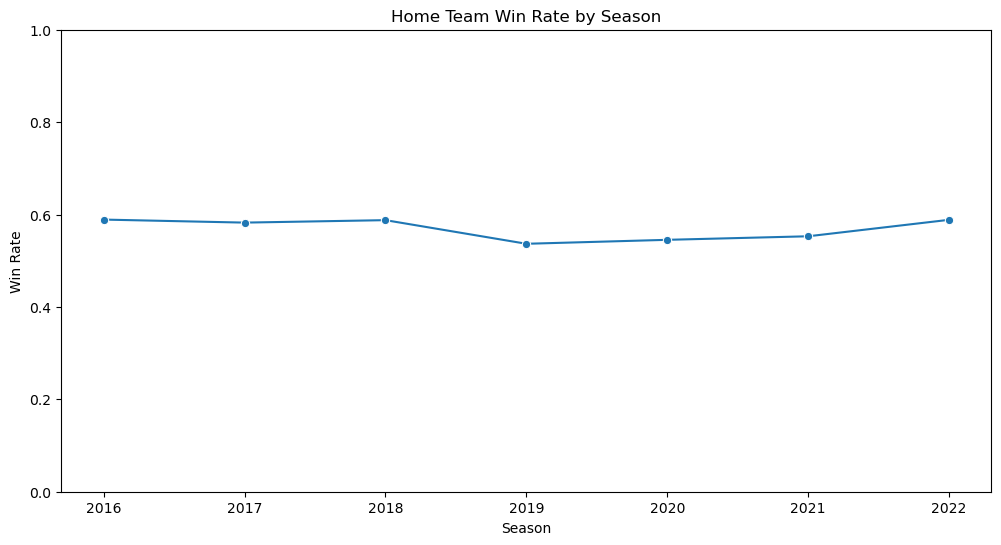

In [38]:
# Calculate the win rate by season
win_rate_by_season = games_df.groupby('SEASON')['HOME_TEAM_WINS'].mean()

# Plot the home team win rate by season
plt.figure(figsize=(12, 6))
sns.lineplot(x=win_rate_by_season.index, y=win_rate_by_season.values, marker='o')
plt.title('Home Team Win Rate by Season')
plt.xlabel('Season')
plt.ylabel('Win Rate')
plt.ylim(0, 1)
plt.show()


In [4]:
details_df = pd.read_csv('games_details.csv')
details_df.head()

/var/folders/y5/3b7y1ppj1dq4pv5pyd26ts0h0000gn/T/ipykernel_79887/1978113452.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  details_df = pd.read_csv('games_details.csv')


,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,NICKNAME,START_POSITION,COMMENT,MIN,...,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS
0,22200477,1610612759,SAS,San Antonio,1629641,Romeo Langford,Romeo,F,NaN,18:06,...,1.0,1.0,2.0,0.0,1.0,0.0,2.0,5.0,2.0,-2.0
1,22200477,1610612759,SAS,San Antonio,1631110,Jeremy Sochan,Jeremy,F,NaN,31:01,...,6.0,3.0,9.0,6.0,1.0,0.0,2.0,1.0,23.0,-14.0
2,22200477,1610612759,SAS,San Antonio,1627751,Jakob Poeltl,Jakob,C,NaN,21:42,...,1.0,3.0,4.0,1.0,1.0,0.0,2.0,4.0,13.0,-4.0
3,22200477,1610612759,SAS,San Antonio,1630170,Devin Vassell,Devin,G,NaN,30:20,...,0.0,9.0,9.0,5.0,3.0,0.0,2.0,1.0,10.0,-18.0
4,22200477,1610612759,SAS,San Antonio,1630200,Tre Jones,Tre,G,NaN,27:44,...,0.0,2.0,2.0,3.0,0.0,0.0,2.0,2.0,19.0,0.0


In [44]:
#For space considerations, we drop all games prior to 2017
drop_ids = [] 
for index, row in games_df.iterrows():
    year_str = row['GAME_DATE_EST']
    year = int(year_str[0:4])
    if(year < 2017):
        drop_ids.append(row['GAME_ID'])

games_df = games_df[~games_df['GAME_ID'].isin(drop_ids)]
details_df = details_df[~details_df['GAME_ID'].isin(drop_ids)]

games_df.reset_index(drop=True, inplace=True)
details_df.reset_index(drop=True, inplace=True)




In [6]:
num_rows = details_df.shape[0]
# Initialize the data structure
player_stats = {}


# Construct the data structure
for index, row in tqdm(details_df.iterrows(), total=num_rows, desc="Processing rows"):
    player_name = row['PLAYER_NAME']
    game_id = row['GAME_ID']
    player_statistics = row.drop(['PLAYER_NAME', 'GAME_ID', 'TEAM_ID', 'TEAM_CITY', 'PLAYER_ID', 'NICKNAME','START_POSITION','COMMENT','TEAM_ABBREVIATION'])
    if player_statistics.isnull().any():
        continue
    player_statistics = player_statistics.to_dict()
    if player_name not in player_stats:
        player_stats[player_name] = {}
    
    player_stats[player_name][game_id] = player_statistics

Processing rows: 100%|██████████| 208536/208536 [00:20<00:00, 10023.89it/s]


Now that player_stats is populated, let's build a hash from player to a sorted list of game_ids so that looking up the previous 3 games is easy

In [7]:
player_games_sorted = {}
for index, row in tqdm(details_df.iterrows(), total=num_rows, desc="Processing rows"):
    player_name = row['PLAYER_NAME']
    game_id = row['GAME_ID']

    if player_name not in player_games_sorted:
        player_games_sorted[player_name] = [game_id]
    else:
        player_games_sorted[player_name].append(game_id)
        player_games_sorted[player_name].sort()

Processing rows:   0%|          | 0/208536 [00:00<?, ?it/s]

Processing rows: 100%|██████████| 208536/208536 [00:03<00:00, 61483.32it/s]


In [8]:
def dict_entry_to_numpy(dict_entry):
    time_str = dict_entry['MIN']
    try:
        if ':' in time_str:
            minutes, seconds = map(int, time_str.split(':'))
            total_minutes = minutes * 60 + seconds
        else:
            total_minutes = float(time_str) * 60  # Assuming it's in minutes as a float
    except ValueError:
        total_minutes = 0.0  # Default to 0 if the format is incorrect or missing

    new_entry = dict_entry.copy()
    new_entry['MIN'] = total_minutes
    values_array = np.array(list(new_entry.values()))
    return values_array


In [9]:
# Function to find past three game IDs
def findPastThreeIDs(player_name, target_game=None):
    if player_name not in player_games_sorted:
        return np.zeros(20 * 3)  # Assuming each entry has 20 features and we need three entries
    foundarr = []
    for game_id in player_games_sorted[player_name]:
        if game_id == target_game:
            break
        try:
            foundarr.append(dict_entry_to_numpy(player_stats[player_name][game_id]))
        except KeyError:
            continue
    if len(foundarr) < 3:
        return np.concatenate([np.zeros(20)] * (3 - len(foundarr)) + foundarr)
    return np.concatenate(foundarr[-3:])

The following is example usage of the above funciton, getting the tensor for a player and the three previous starting games before the one specified

In [10]:
findPastThreeIDs("Romeo Langford", 22200477)

array([ 1.719e+03,  7.000e+00,  1.000e+01,  7.000e-01,  1.000e+00,
        2.000e+00,  5.000e-01,  4.000e+00,  4.000e+00,  1.000e+00,
        1.000e+00,  5.000e+00,  6.000e+00,  0.000e+00,  1.000e+00,
        1.000e+00,  2.000e+00,  3.000e+00,  1.900e+01, -3.000e+00,
        1.491e+03,  1.000e+00,  5.000e+00,  2.000e-01,  0.000e+00,
        2.000e+00,  0.000e+00,  1.000e+00,  2.000e+00,  5.000e-01,
        2.000e+00,  1.000e+00,  3.000e+00,  1.000e+00,  1.000e+00,
        1.000e+00,  0.000e+00,  1.000e+00,  3.000e+00, -1.200e+01,
        1.154e+03,  2.000e+00,  2.000e+00,  1.000e+00,  1.000e+00,
        1.000e+00,  1.000e+00,  1.000e+00,  2.000e+00,  5.000e-01,
        0.000e+00,  1.000e+00,  1.000e+00,  1.000e+00,  0.000e+00,
        1.000e+00,  0.000e+00,  1.000e+00,  6.000e+00,  3.000e+00])

In [11]:
# Function to get tensor from game ID
def getTensorFromID(id, game_details_df):
    filtered_df = game_details_df[(game_details_df['GAME_ID'] == id) & (game_details_df['START_POSITION'].notna())]
    tensor = np.array([], dtype=float)
    for index, row in filtered_df.iterrows():
        player_tensor = findPastThreeIDs(row['PLAYER_NAME'], id)
        tensor = np.concatenate((tensor, player_tensor))
    return tensor 

Example usage of the above function. This allows us to get an input tensor for a specfied game. So, to train on data, simply run this function to get all input points on the games you want to train on. 

In [12]:
getTensorFromID(22200477, details_df)

array([ 1.719e+03,  7.000e+00,  1.000e+01,  7.000e-01,  1.000e+00,
        2.000e+00,  5.000e-01,  4.000e+00,  4.000e+00,  1.000e+00,
        1.000e+00,  5.000e+00,  6.000e+00,  0.000e+00,  1.000e+00,
        1.000e+00,  2.000e+00,  3.000e+00,  1.900e+01, -3.000e+00,
        1.491e+03,  1.000e+00,  5.000e+00,  2.000e-01,  0.000e+00,
        2.000e+00,  0.000e+00,  1.000e+00,  2.000e+00,  5.000e-01,
        2.000e+00,  1.000e+00,  3.000e+00,  1.000e+00,  1.000e+00,
        1.000e+00,  0.000e+00,  1.000e+00,  3.000e+00, -1.200e+01,
        1.154e+03,  2.000e+00,  2.000e+00,  1.000e+00,  1.000e+00,
        1.000e+00,  1.000e+00,  1.000e+00,  2.000e+00,  5.000e-01,
        0.000e+00,  1.000e+00,  1.000e+00,  1.000e+00,  0.000e+00,
        1.000e+00,  0.000e+00,  1.000e+00,  6.000e+00,  3.000e+00,
        1.289e+03,  2.000e+00,  6.000e+00,  3.330e-01,  0.000e+00,
        0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
        1.000e+00,  4.000e+00,  5.000e+00,  3.000e+00,  0.000e

In [14]:
# Preparing training data
input_tensors = []
output_labels = []
output_scores = []

for index, row in tqdm(games_df.iterrows(), total=games_df.shape[0], desc="Preparing training data"):
    game_id = row['GAME_ID']
    home_team_wins = 1 if row['HOME_TEAM_WINS'] else 0
    home_team_score = row['PTS_home']
    away_team_score = row['PTS_away']
    
    tensor = getTensorFromID(game_id, details_df)
    input_tensors.append(tensor)
    output_labels.append(home_team_wins)
    output_scores.append([home_team_score, away_team_score])

# Determine the maximum tensor length
max_length = max(len(tensor) for tensor in input_tensors)

# Pad tensors to ensure consistent shape
def pad_tensor(tensor, max_length):
    padding = max(0, max_length - len(tensor))
    return np.pad(tensor, (0, padding), 'constant')

input_tensors = [pad_tensor(tensor, max_length) for tensor in input_tensors]

# Convert to numpy arrays
X = np.array(input_tensors)
y = np.array(output_labels)
y_scores = np.array(output_scores)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_scores, X_test_scores, y_train_scores, y_test_scores = train_test_split(X, y_scores, test_size=0.2, random_state=42)


Preparing training data: 100%|██████████| 7984/7984 [00:58<00:00, 136.19it/s]


In [28]:
# Train Random Forest Classifier
clf = RandomForestClassifier(n_estimators=200, random_state=42, verbose=False, n_jobs=-1)
clf.fit(X_train, y_train)

# Train Random Forest Regressor
reg = RandomForestRegressor(n_estimators=200, random_state=42, verbose=False, n_jobs=-1)
reg.fit(X_train_scores, y_train_scores)

# Evaluate the classifier on training data
y_train_pred = clf.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)

# Evaluate the classifier on test data
y_test_pred = clf.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Evaluate the regressor on training data
y_train_pred_scores = reg.predict(X_train_scores)
train_mse = mean_squared_error(y_train_scores, y_train_pred_scores)

# Evaluate the regressor on test data
y_test_pred_scores = reg.predict(X_test_scores)
test_mse = mean_squared_error(y_test_scores, y_test_pred_scores)

print(f'Training Classifier Accuracy: {train_accuracy:.2f}')
print(f'Training Regressor Mean Squared Error: {train_mse:.2f}')

print(f'Test Classifier Accuracy: {test_accuracy:.2f}')
print(f'Test Regressor Mean Squared Error: {test_mse:.2f}')

Training Classifier Accuracy: 1.00
Training Regressor Mean Squared Error: 21.10
Test Classifier Accuracy: 0.59
Test Regressor Mean Squared Error: 150.42


In [29]:
def predict_game_outcome_and_score(home_team_players, away_team_players):
    home_tensor = np.array([], dtype=float)
    away_tensor = np.array([], dtype=float)
    
    for player in home_team_players:
        home_tensor = np.concatenate((home_tensor, findPastThreeIDs(player, None)))
    
    for player in away_team_players:
        away_tensor = np.concatenate((away_tensor, findPastThreeIDs(player, None)))
    
    home_tensor = pad_tensor(home_tensor, max_length // 2)
    away_tensor = pad_tensor(away_tensor, max_length // 2)
    
    input_tensor = np.concatenate((home_tensor, away_tensor)).reshape(1, -1)
    
    scores = reg.predict(input_tensor)[0]
    home_team_score, away_team_score = int(round(scores[0])), int(round(scores[1]))
    
    # Determine the outcome based on predicted scores
    outcome = 1 if home_team_score > away_team_score else 0
    
    return outcome, (home_team_score, away_team_score)


In [31]:
# Example usage
home_team = ["Bojan Bogdanovic", "Austin Rivers", "Mason Plumlee", "Andre Drummond", "Cedi Osman"]
away_team = ["Kevon Harris", "Terry Rozier", "Udonis Haslem", "Kelly Olynyk", "Devin Booker"]

outcome, scores = predict_game_outcome_and_score(home_team, away_team)

print(f'Predicted Outcome: {"Home Team Wins" if outcome == 1 else "Away Team Wins"}')
print(f'Predicted Scores: Home Team {scores[0]} - Away Team {scores[1]}')

Predicted Outcome: Home Team Wins
Predicted Scores: Home Team 108 - Away Team 105
